In [55]:
import healpy
import lunarsky
import matplotlib.pyplot as plt
from pygdsm import GlobalSkyModel2016
import pyradiosky
import pyuvdata
import numpy as np
import uvtools

## Import Beams

In [157]:
from pathlib import Path
uvb_path = "/home/christian/Documents/research/lusee/lusee_sky_simulations/luseesky/uvbeams/AntennaSimResults/004_Freq1-50MHz_Delta1MHz_AntennaLength1-6m_Delta1m_AntennaAngle75deg_LanderHeight2m/phase180/simlengths/"
beamfiles = [str(p) for p in Path(uvb_path).iterdir()]

In [158]:
beamfiles = np.array(beamfiles)

In [119]:
uvb=pyuvdata.UVBeam()
uvb.read_beamfits(beamfiles[0])

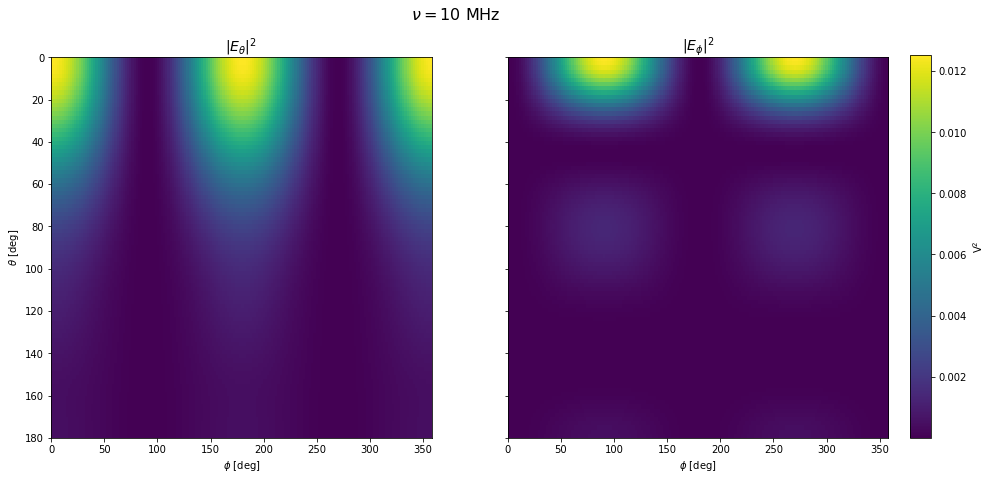

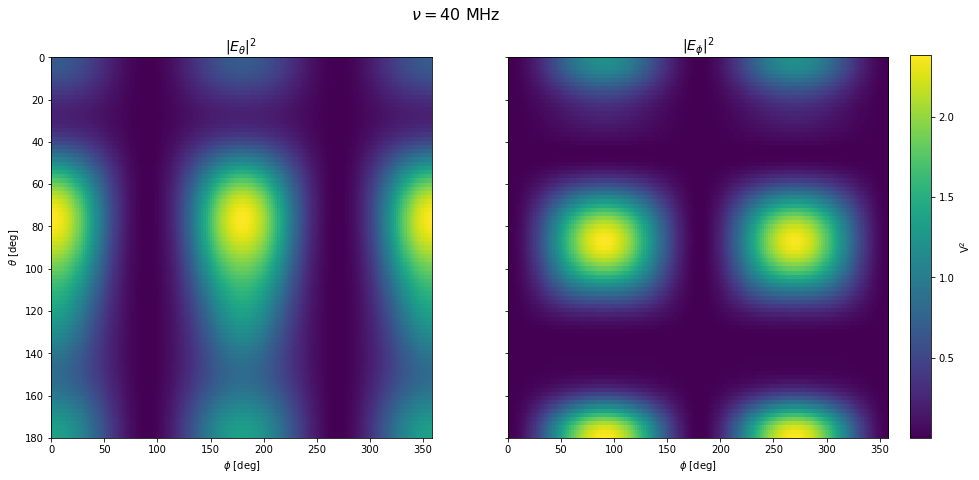

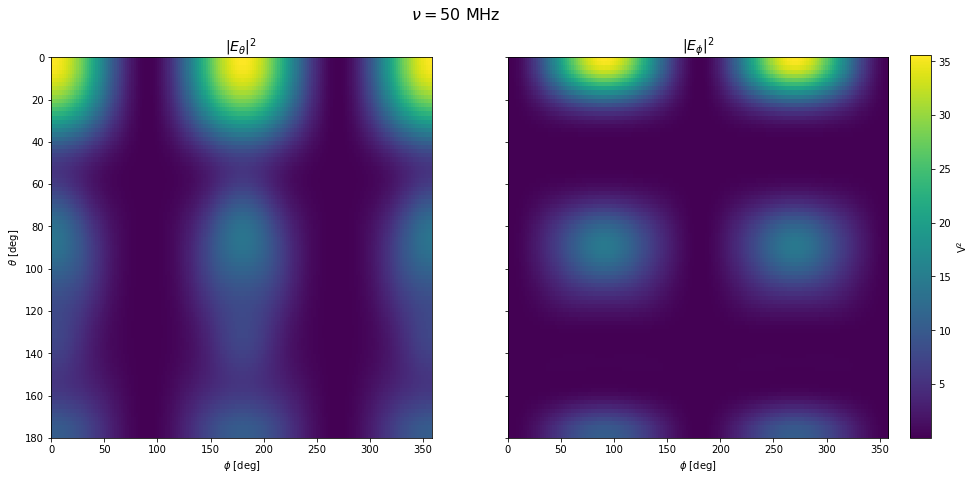

In [60]:
left, right = np.degrees(uvb.axis1_array).min(), np.degrees(uvb.axis1_array).max()
top, bottom = np.degrees(uvb.axis2_array).min(), np.degrees(uvb.axis2_array).max()
extent = [left, right, bottom, top]
components = ["$|E_\\theta|^2$", "$|E_\phi|^2$"]

for freq in [10, 40, 50]:
    find = np.argmin(np.abs(uvb.freq_array[0] - freq*1e6))
    fig, axs = plt.subplots(figsize=(15,7), ncols=2, sharex=True, sharey=True)
    for i, ax in enumerate(axs):
        im = ax.imshow(np.abs(uvb.data_array[i, 0, 0, find])**2, interpolation="none", aspect="auto", extent=extent)
        ax.set_xlabel("$\\phi$ [deg]")
        if i == 0:
            ax.set_ylabel("$\\theta$ [deg]")
        ax.set_title(components[i], fontsize=14)
    cax=fig.add_axes([0.92, 0.125, .02, .76])
    plt.colorbar(im, cax, label="$\\rm{V}^2$")
    plt.suptitle('$\\nu={:.0f}$ MHz'.format(uvb.freq_array[0, find]/1e6), fontsize=16)
    plt.show()

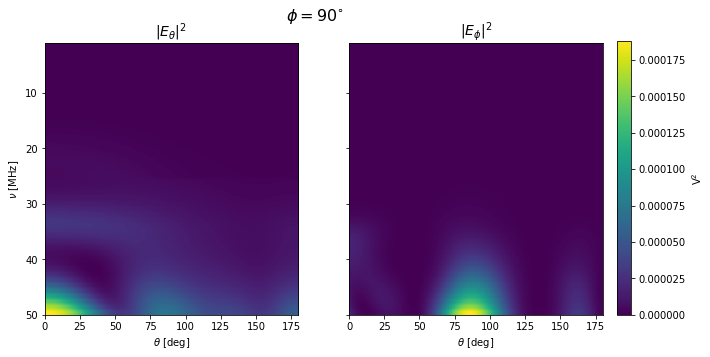

In [61]:
lt, rt = np.degrees(uvb.axis2_array).min(), np.degrees(uvb.axis2_array).max()
tf, bf = uvb.freq_array[0].min()/1e6, uvb.freq_array[0].max()/1e6
ex_tf = [lt, rt, bf, tf]
components = ["$|E_\\theta|^2$", "$|E_\phi|^2$"]

fig, axs = plt.subplots(figsize=(10, 5), ncols=2, sharex=True, sharey=True)
for i, ax in enumerate(axs.ravel()):
    col = i
    im = ax.imshow(np.abs(uvb.data_array[col, 0, 0, :, :, 90]**2), aspect="auto", extent=ex_tf)
    ax.set_title(components[i], fontsize=14)
    ax.set_xlabel("$\\theta$ [deg]")
    if i == 0:
        ax.set_ylabel("$\\nu$ [MHz]")
cax=fig.add_axes([0.92, 0.125, .02, .76])
plt.colorbar(im, cax, label="$\\rm{V}^2$")
plt.suptitle("$\\phi = 90^{\circ}$", fontsize=16)
plt.show()

In [62]:
power_uvb = uvb.efield_to_power(calc_cross_pols=True, inplace=False)
power_uvb.to_healpix()

Casting complex values to real discards the imaginary part


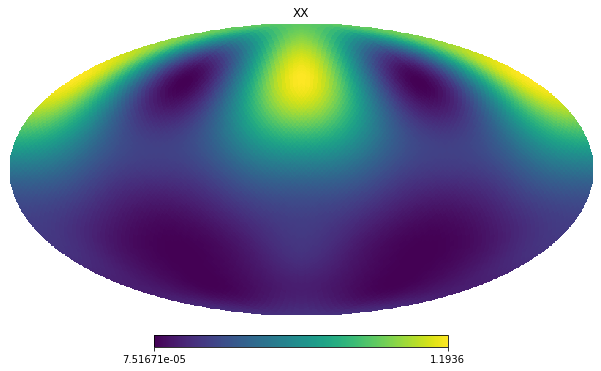

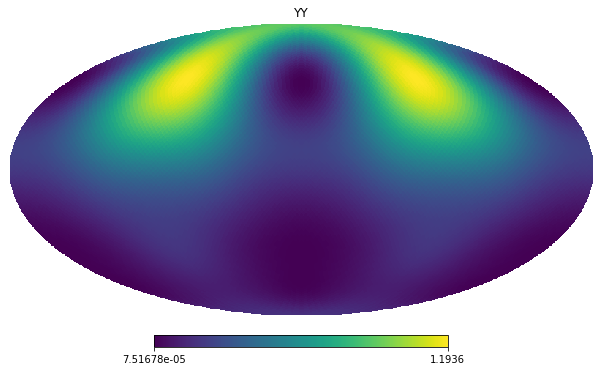

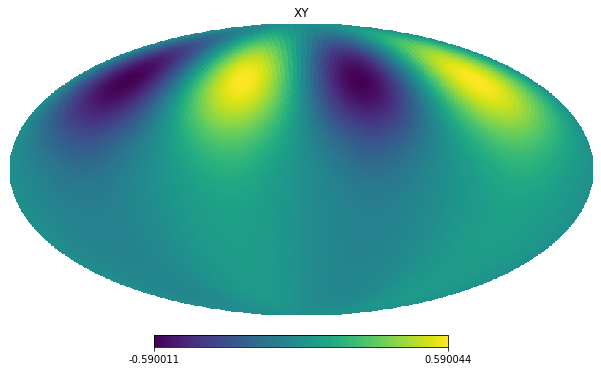

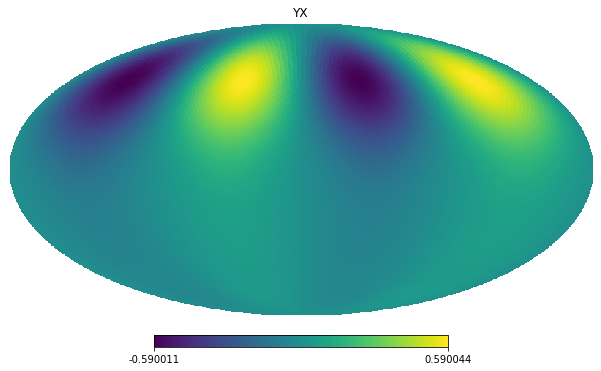

In [63]:
FREQ = 25e6
FIND = np.argwhere(power_uvb.freq_array[0] == FREQ)[0,0]
healpy.mollview(power_uvb.data_array[0, 0, 0, FIND], title="XX")
healpy.mollview(power_uvb.data_array[0, 0, 1, FIND], title="YY")
healpy.mollview(power_uvb.data_array[0, 0, 2, FIND], title="XY")
healpy.mollview(power_uvb.data_array[0, 0, 3, FIND], title="YX")

Casting complex values to real discards the imaginary part


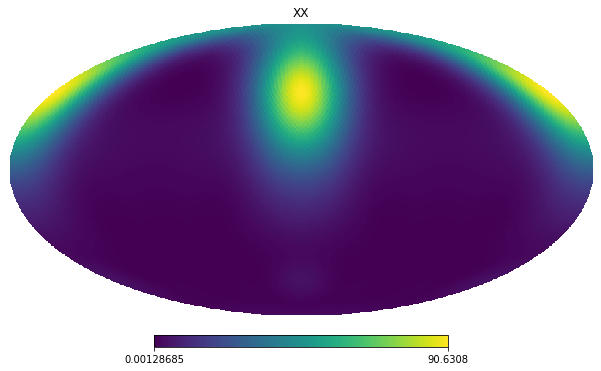

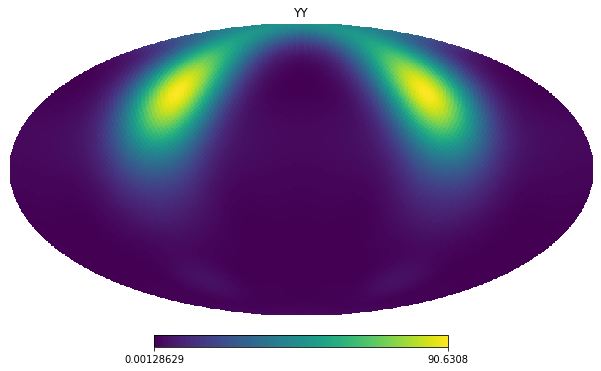

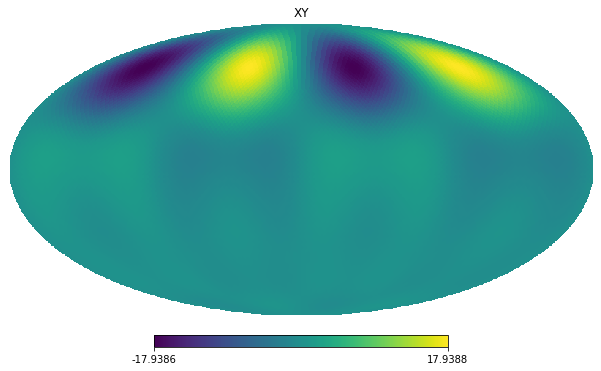

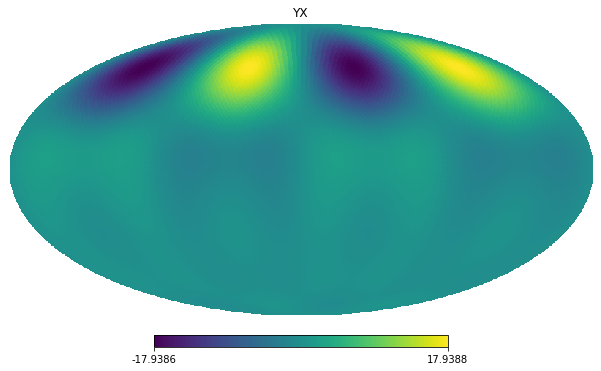

In [159]:
uvb=pyuvdata.UVBeam()
uvb.read_beamfits(beamfiles[2])

power_uvb = uvb.efield_to_power(calc_cross_pols=True, inplace=False)
power_uvb.to_healpix()

FREQ = 25e6
FIND = np.argwhere(power_uvb.freq_array[0] == FREQ)[0,0]
healpy.mollview(power_uvb.data_array[0, 0, 0, FIND], title="XX")
healpy.mollview(power_uvb.data_array[0, 0, 1, FIND], title="YY")
healpy.mollview(power_uvb.data_array[0, 0, 2, FIND], title="XY")
healpy.mollview(power_uvb.data_array[0, 0, 3, FIND], title="YX")

## Load skymodel

In [64]:
rot = healpy.Rotator(coord=['G','C'])

invalid value encountered in log2


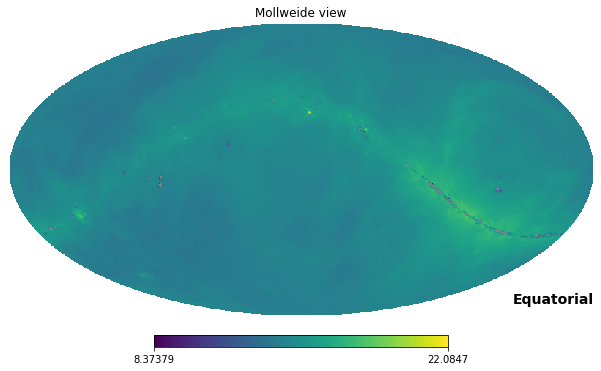

In [65]:
REF_FREQ = 25  # MHz
gsm = GlobalSkyModel2016(freq_unit='MHz')
gsm.generate(REF_FREQ)
healpy.mollview(np.log2(rot.rotate_map_pixel(gsm.generated_map_data)), rot=[0, 30, 0], coord="C")
#gsm.view(logged=True)  # calling mollview with default components, nest=False

invalid value encountered in log2


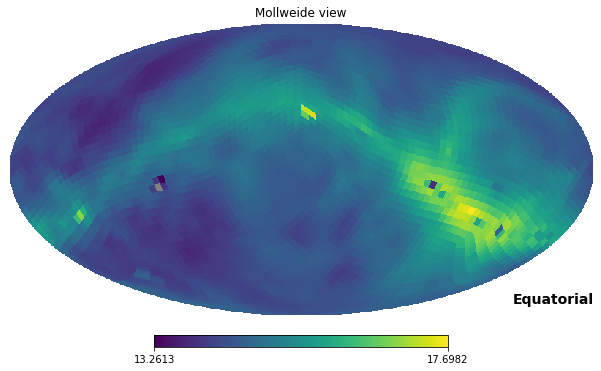

In [66]:
# averagng
degr = healpy.ud_grade(gsm.generated_map_data, nside_out=16, order_in="RING", order_out="RING")
healpy.mollview(np.log2(rot.rotate_map_pixel(degr)), rot=[0, 30, 0], coord="C")

In [67]:
print(f"Reducing the number of pixels by {round(gsm.generated_map_data.size / degr.size)}.")

Reducing the number of pixels by 4096.


In [68]:
# the actual sky model used after filtering
skymodel = pyradiosky.SkyModel()
skymodel.read_text_catalog("../luseesky/skymodels/pygdsm16_nside16.txt")
print(skymodel.stokes.unit)

Jy


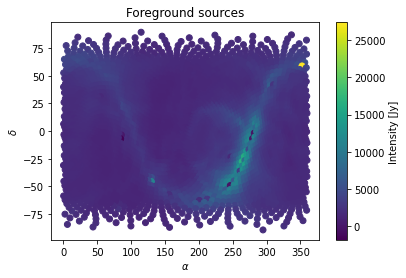

In [69]:
plt.figure()
#plt.subplot(projection="mollweide")
#plt.scatter(skymodel.ra.rad, skymodel.dec.rad, c=skymodel.stokes[0,0].value)
plt.scatter(skymodel.ra.deg, skymodel.dec.deg, c=skymodel.stokes[0,0].value)
plt.xlabel("$\\alpha$")
plt.ylabel("$\\delta$")
plt.colorbar(label="Intensity [Jy]")
plt.title("Foreground sources")
plt.show()

## Load UVSim Results and Compute Eigenmodes

In [70]:
def eigenmode_matrix(vis):
    d = vis - np.mean(vis, axis=0)  # subtract mean in time
    C = np.dot(d.T, d)  # covariance matrix
    U, S, V = np.linalg.svd(C)  # V is actually V transpose
    return V

In [71]:
def eigenmodes(V, n_modes):
    # V is the V of the SVD (numpy return, not math V)
    modes = V[:n_modes].T
    return modes

In [72]:
def to_eigenbasis(vis, V, lst_idx=0):
    idata = vis[lst_idx, :]  # specific lst
    return np.abs(V @ idata.T)

In [73]:
def period_idx(lst):
    """
    Get the idx of which lst wraps around.
    """
    diff = lst - lst[0]
    # the diff is first positve, then negative, then positive again
    zerocross = np.where(np.diff(np.sign(diff)))[0] + 1 # the index after a zero cross
    assert len(zerocross) == 3
    return zerocross[2]

In [95]:
uvresults = Path("/home/christian/Documents/research/lusee/lusee_sky_simulations/luseesky/results/004_Freq1-50MHz_Delta1MHz_AntennaLength1-6m_Delta1m_AntennaAngle75deg_LanderHeight2m/phase180/simlengths")
uvresults = [str(p) for p in Path(uvresults).iterdir()]

In [96]:
uvresults = np.array(uvresults)[::-1]
print(uvresults)

['/home/christian/Documents/research/lusee/lusee_sky_simulations/luseesky/results/004_Freq1-50MHz_Delta1MHz_AntennaLength1-6m_Delta1m_AntennaAngle75deg_LanderHeight2m/phase180/simlengths/RadiatedElectricField_AntennaLength1m_AntennaAngle75deg_LanderHeight2m_LBoxZ70cm_Phase+180deg.npz'
 '/home/christian/Documents/research/lusee/lusee_sky_simulations/luseesky/results/004_Freq1-50MHz_Delta1MHz_AntennaLength1-6m_Delta1m_AntennaAngle75deg_LanderHeight2m/phase180/simlengths/RadiatedElectricField_AntennaLength4m_AntennaAngle75deg_LanderHeight2m_LBoxZ70cm_Phase+180deg.npz'
 '/home/christian/Documents/research/lusee/lusee_sky_simulations/luseesky/results/004_Freq1-50MHz_Delta1MHz_AntennaLength1-6m_Delta1m_AntennaAngle75deg_LanderHeight2m/phase180/simlengths/RadiatedElectricField_AntennaLength6m_AntennaAngle75deg_LanderHeight2m_LBoxZ70cm_Phase+180deg.npz']


In [203]:
#CLIM = (3.5, 8.)
CLIM = (3, 8)

In [204]:
def jy2k(jy, freq):
    #jy /= 4*np.pi  # Jy/Sr
    wave = 3.00e8/freq  # lambda
    k = 1.38e-23  # boltzmann
    jy *= 1e-26  # convert to SI
    temp = wave**2 * jy / (2*k)
    return temp

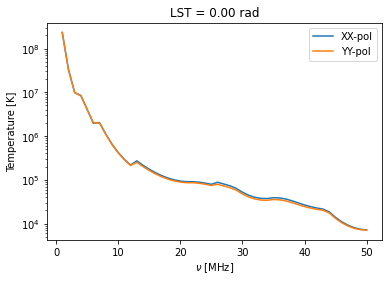

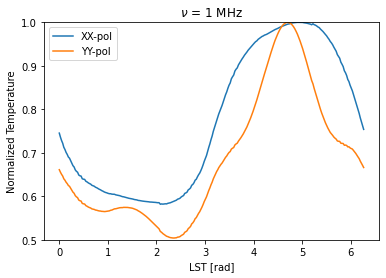

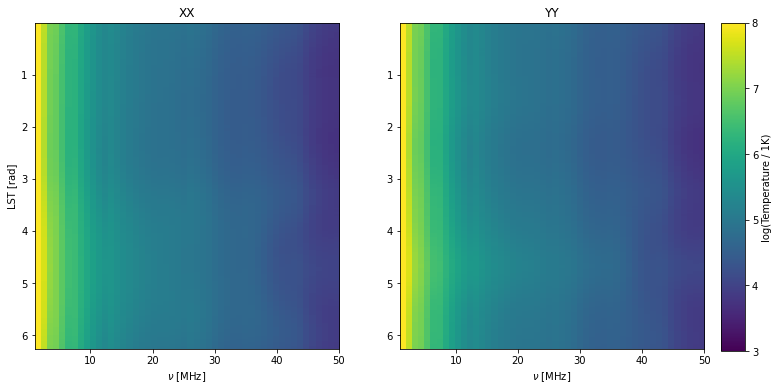

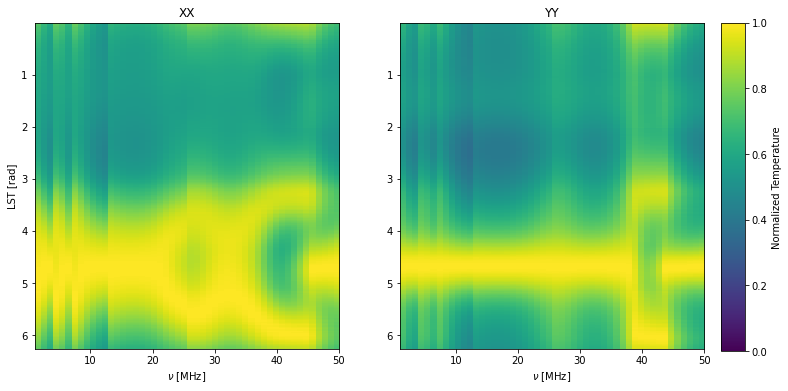

In [205]:
IDX = 0

uvdata = np.load(uvresults[IDX])
vis = uvdata["data"][:, :, :2]
vis = vis.real
freq = uvdata["freq"]
lst_arr = uvdata["lst"]

freq_vis = np.expand_dims(freq, axis=0)
freq_vis = np.expand_dims(freq_vis, axis=-1)
freq_vis = np.repeat(freq_vis, vis.shape[0], axis=0)
freq_vis = np.repeat(freq_vis, vis.shape[-1], axis=-1)
vis = jy2k(vis, freq_vis)

uvb=pyuvdata.UVBeam()
uvb.read_beamfits(beamfiles[IDX])
power_uvb = uvb.efield_to_power(calc_cross_pols=False, inplace=False)
power_uvb.to_healpix()
# norm = np.repeat(np.expand_dims(np.sqrt(power_uvb.data_array[0, 0, :2]).sum(axis=-1).T.real, axis=0), 256, axis=0)
#norm = np.repeat(np.expand_dims(np.sqrt(power_uvb.data_array[0, 0, :2]).max(axis=-1).T.real, axis=0), 256, axis=0)
norm1 = np.sqrt(power_uvb.data_array[0, 0, 0]).real.max()
norm2 = np.sqrt(power_uvb.data_array[0, 0, 1]).real.max()
vis[:, :, 0] /= norm1
vis[:, :, 1] /= norm2
vis *= 10

# cut to one orbital period
pidx = period_idx(lst_arr)
lst_arr = lst_arr[:pidx]
vis = vis[:pidx]

shift = -lst_arr.argmin()
lst_arr = np.roll(lst_arr, shift)
vis = np.roll(vis, shift, axis=0)

plt.figure()
plt.plot(freq/1e6, vis[0, :, 0], label="XX-pol")
#plt.plot(freq/1e6, (freq/freq[0])**(-2.5)*vis[0, 0, 0], label="powerlaw")
plt.plot(freq/1e6, vis[0, :, 1], label="YY-pol")
plt.legend()
plt.xlabel("$\\nu$ [MHz]")
plt.ylabel("Temperature [K]")
plt.title("LST = {:.2f} rad".format(lst_arr[0]))
plt.yscale("log")
plt.show()

plt.figure()
plt.plot(lst_arr, vis[:, 0, 0]/vis[:, 0, 0].max(), label="XX-pol")
plt.plot(lst_arr, vis[:, 0, 1]/vis[:, 0, 1].max(), label="YY-pol")
plt.legend()
plt.xlabel("LST [rad]")
plt.ylabel("Normalized Temperature")
plt.title("$\\nu$ = {:.0f} MHz".format(freq[0]/1e6))
plt.ylim(0.5, 1)
plt.show()



extent = [freq.min()/1e6, freq.max()/1e6, lst_arr.max(), lst_arr.min()]

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
#im = uvtools.plot.waterfall(vis[:, :, 0], mode='real', extent=extent)
im = uvtools.plot.waterfall(np.log10(vis[:, :, 0]), mode='real', extent=extent)
#im = uvtools.plot.waterfall(vis[:, :, 0]/vis[:, :, 0].max(axis=0), mode='real', extent=extent)
im.set_clim(*CLIM)
plt.title("XX")
plt.xlabel("$\\nu$ [MHz]")
plt.ylabel("LST [rad]")
plt.subplot(122)
#im = uvtools.plot.waterfall(vis[:, :, 1], mode='real', extent=extent)
im = uvtools.plot.waterfall(np.log10(vis[:, :, 1]), mode='real', extent=extent)
#im = uvtools.plot.waterfall(vis[:, :, 1]/vis[:, :, 1].max(axis=0), mode='real', extent=extent)
im.set_clim(*CLIM)
plt.title("YY")
plt.xlabel("$\\nu$ [MHz]")
cax = fig.add_axes([0.92, 0.12, 0.027, 0.76])
_ = plt.colorbar(cax=cax, label="log(Temperature / 1K)")

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
im = uvtools.plot.waterfall(vis[:, :, 0]/vis[:, :, 0].max(axis=0), mode='real', extent=extent)
im.set_clim(0, 1)
plt.title("XX")
plt.xlabel("$\\nu$ [MHz]")
plt.ylabel("LST [rad]")
plt.subplot(122)
im = uvtools.plot.waterfall(vis[:, :, 1]/vis[:, :, 1].max(axis=0), mode='real', extent=extent)
im.set_clim(0, 1)
plt.title("YY")
plt.xlabel("$\\nu$ [MHz]")
cax = fig.add_axes([0.92, 0.12, 0.027, 0.76])
_ = plt.colorbar(cax=cax, label="Normalized Temperature")


vis = vis[:, :, 0]  # only XX
V_1m = eigenmode_matrix(vis)
fg_freq_1m = vis[0, :]
fg_eig_1m = to_eigenbasis(vis, V_1m)

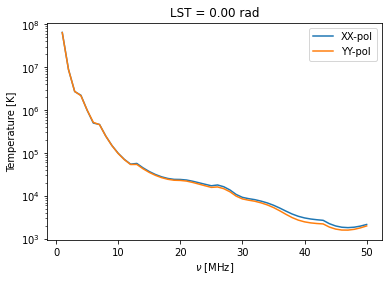

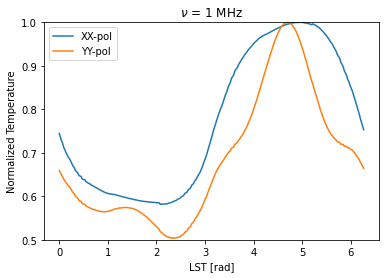

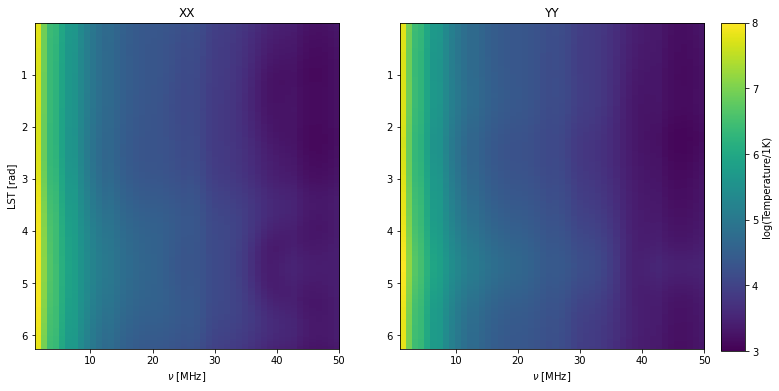

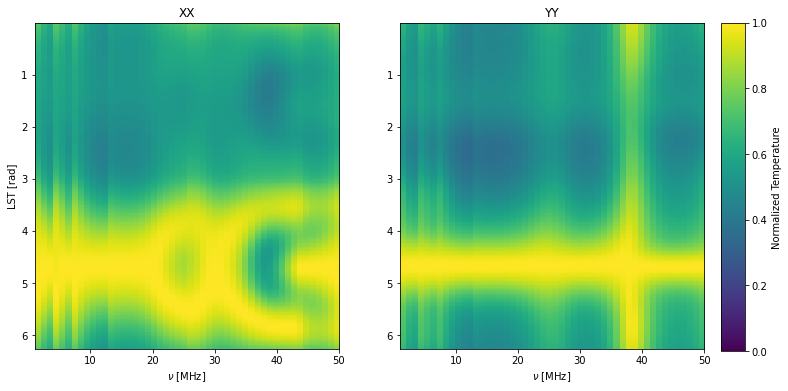

In [206]:
IDX = 1

uvdata = np.load(uvresults[IDX])
vis = uvdata["data"][:, :, :2]
vis = vis.real
freq = uvdata["freq"]
lst_arr = uvdata["lst"]

freq_vis = np.expand_dims(freq, axis=0)
freq_vis = np.expand_dims(freq_vis, axis=-1)
freq_vis = np.repeat(freq_vis, vis.shape[0], axis=0)
freq_vis = np.repeat(freq_vis, vis.shape[-1], axis=-1)
vis = jy2k(vis, freq_vis)

uvb=pyuvdata.UVBeam()
uvb.read_beamfits(beamfiles[IDX])
power_uvb = uvb.efield_to_power(calc_cross_pols=False, inplace=False)
power_uvb.to_healpix()
# norm = np.repeat(np.expand_dims(np.sqrt(power_uvb.data_array[0, 0, :2]).sum(axis=-1).T.real, axis=0), 256, axis=0)
#norm = np.repeat(np.expand_dims(np.sqrt(power_uvb.data_array[0, 0, :2]).max(axis=-1).T.real, axis=0), 256, axis=0)
norm1 = np.sqrt(power_uvb.data_array[0, 0, 0]).real.max()
norm2 = np.sqrt(power_uvb.data_array[0, 0, 1]).real.max()
vis[:, :, 0] /= norm1
vis[:, :, 1] /= norm2
vis *= 10

# cut to one orbital period
pidx = period_idx(lst_arr)
lst_arr = lst_arr[:pidx]
vis = vis[:pidx]

shift = -lst_arr.argmin()
lst_arr = np.roll(lst_arr, shift)
vis = np.roll(vis, shift, axis=0)

plt.figure()
plt.plot(freq/1e6, vis[0, :, 0], label="XX-pol")
#plt.plot(freq/1e6, (freq/freq[0])**(-2.5)*vis[0, 0, 0], label="powerlaw")
plt.plot(freq/1e6, vis[0, :, 1], label="YY-pol")
plt.legend()
plt.xlabel("$\\nu$ [MHz]")
plt.ylabel("Temperature [K]")
plt.title("LST = {:.2f} rad".format(lst_arr[0]))
plt.yscale("log")
plt.show()

plt.figure()
plt.plot(lst_arr, vis[:, 0, 0]/vis[:, 0, 0].max(), label="XX-pol")
plt.plot(lst_arr, vis[:, 0, 1]/vis[:, 0, 1].max(), label="YY-pol")
plt.legend()
plt.xlabel("LST [rad]")
plt.ylabel("Normalized Temperature")
plt.title("$\\nu$ = {:.0f} MHz".format(freq[0]/1e6))
plt.ylim(0.5, 1)
plt.show()



extent = [freq.min()/1e6, freq.max()/1e6, lst_arr.max(), lst_arr.min()]

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
#im = uvtools.plot.waterfall(vis[:, :, 0], mode='real', extent=extent)
im = uvtools.plot.waterfall(np.log10(vis[:, :, 0]), mode='real', extent=extent)
#im = uvtools.plot.waterfall(vis[:, :, 0]/vis[:, :, 0].max(axis=0), mode='real', extent=extent)
im.set_clim(*CLIM)
plt.title("XX")
plt.xlabel("$\\nu$ [MHz]")
plt.ylabel("LST [rad]")
plt.subplot(122)
#im = uvtools.plot.waterfall(vis[:, :, 1], mode='real', extent=extent)
im = uvtools.plot.waterfall(np.log10(vis[:, :, 1]), mode='real', extent=extent)
#im = uvtools.plot.waterfall(vis[:, :, 1]/vis[:, :, 1].max(axis=0), mode='real', extent=extent)
im.set_clim(*CLIM)
plt.title("YY")
plt.xlabel("$\\nu$ [MHz]")
cax = fig.add_axes([0.92, 0.12, 0.027, 0.76])
_ = plt.colorbar(cax=cax, label="log(Temperature/1K)")

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
#lmax = vis[:, :, 0].sum(axis=1).argmax()
im = uvtools.plot.waterfall(vis[:, :, 0]/vis[:, :, 0].max(axis=0), mode='real', extent=extent)
im.set_clim(0, 1)
plt.title("XX")
plt.xlabel("$\\nu$ [MHz]")
plt.ylabel("LST [rad]")
plt.subplot(122)
im = uvtools.plot.waterfall(vis[:, :, 1]/vis[:, :, 1].max(axis=0), mode='real', extent=extent)
im.set_clim(0, 1)
plt.title("YY")
plt.xlabel("$\\nu$ [MHz]")
cax = fig.add_axes([0.92, 0.12, 0.027, 0.76])
_ = plt.colorbar(cax=cax, label="Normalized Temperature")


vis = vis[:, :, 0]  # only XX
V_4m = eigenmode_matrix(vis)
fg_freq_4m = vis[0, :]
fg_eig_4m = to_eigenbasis(vis, V_4m)

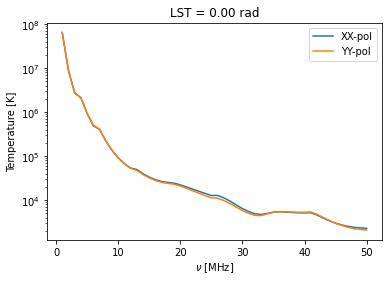

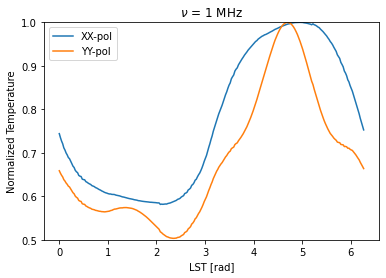

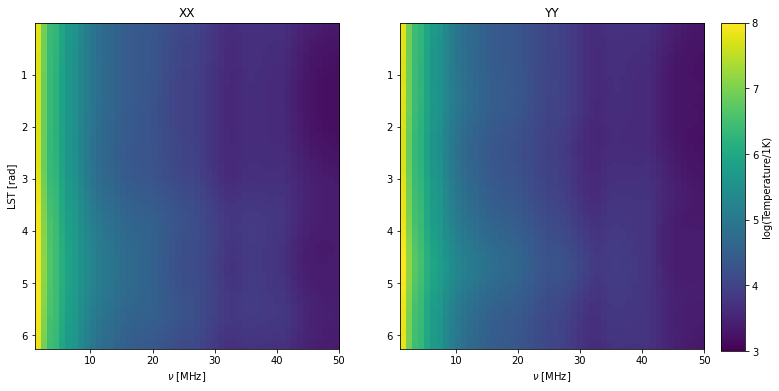

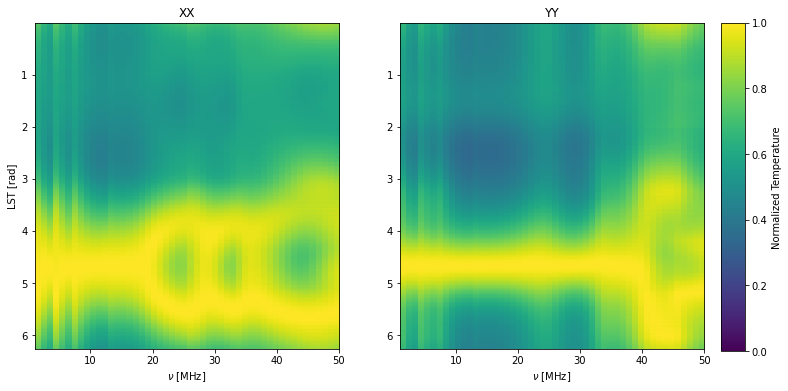

In [207]:
IDX = 2

uvdata = np.load(uvresults[IDX])
vis = uvdata["data"][:, :, :2]
vis = vis.real
freq = uvdata["freq"]
lst_arr = uvdata["lst"]

freq_vis = np.expand_dims(freq, axis=0)
freq_vis = np.expand_dims(freq_vis, axis=-1)
freq_vis = np.repeat(freq_vis, vis.shape[0], axis=0)
freq_vis = np.repeat(freq_vis, vis.shape[-1], axis=-1)
vis = jy2k(vis, freq_vis)

uvb=pyuvdata.UVBeam()
uvb.read_beamfits(beamfiles[IDX])
power_uvb = uvb.efield_to_power(calc_cross_pols=False, inplace=False)
power_uvb.to_healpix()
# norm = np.repeat(np.expand_dims(np.sqrt(power_uvb.data_array[0, 0, :2]).sum(axis=-1).T.real, axis=0), 256, axis=0)
#norm = np.repeat(np.expand_dims(np.sqrt(power_uvb.data_array[0, 0, :2]).max(axis=-1).T.real, axis=0), 256, axis=0)
norm1 = np.sqrt(power_uvb.data_array[0, 0, 0]).real.max()
norm2 = np.sqrt(power_uvb.data_array[0, 0, 1]).real.max()
vis[:, :, 0] /= norm1
vis[:, :, 1] /= norm2
vis *= 10

# cut to one orbital period
pidx = period_idx(lst_arr)
lst_arr = lst_arr[:pidx]
vis = vis[:pidx]

shift = -lst_arr.argmin()
lst_arr = np.roll(lst_arr, shift)
vis = np.roll(vis, shift, axis=0)

plt.figure()
plt.plot(freq/1e6, vis[0, :, 0], label="XX-pol")
#plt.plot(freq/1e6, (freq/freq[0])**(-2.5)*vis[0, 0, 0], label="powerlaw")
plt.plot(freq/1e6, vis[0, :, 1], label="YY-pol")
plt.legend()
plt.xlabel("$\\nu$ [MHz]")
plt.ylabel("Temperature [K]")
plt.title("LST = {:.2f} rad".format(lst_arr[0]))
plt.yscale("log")
plt.show()

plt.figure()
plt.plot(lst_arr, vis[:, 0, 0]/vis[:, 0, 0].max(), label="XX-pol")
plt.plot(lst_arr, vis[:, 0, 1]/vis[:, 0, 1].max(), label="YY-pol")
plt.legend()
plt.xlabel("LST [rad]")
plt.ylabel("Normalized Temperature")
plt.title("$\\nu$ = {:.0f} MHz".format(freq[0]/1e6))
plt.ylim(0.5, 1)
plt.show()



extent = [freq.min()/1e6, freq.max()/1e6, lst_arr.max(), lst_arr.min()]

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
#im = uvtools.plot.waterfall(vis[:, :, 0], mode='real', extent=extent)
im = uvtools.plot.waterfall(np.log10(vis[:, :, 0]), mode='real', extent=extent)
#im = uvtools.plot.waterfall(vis[:, :, 0]/vis[:, :, 0].max(axis=0), mode='real', extent=extent)
im.set_clim(*CLIM)
plt.title("XX")
plt.xlabel("$\\nu$ [MHz]")
plt.ylabel("LST [rad]")
plt.subplot(122)
#im = uvtools.plot.waterfall(vis[:, :, 1], mode='real', extent=extent)
im = uvtools.plot.waterfall(np.log10(vis[:, :, 1]), mode='real', extent=extent)
#im = uvtools.plot.waterfall(vis[:, :, 1]/vis[:, :, 1].max(axis=0), mode='real', extent=extent)
im.set_clim(*CLIM)
plt.title("YY")
plt.xlabel("$\\nu$ [MHz]")
cax = fig.add_axes([0.92, 0.12, 0.027, 0.76])
_ = plt.colorbar(cax=cax, label="log(Temperature/1K)")

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
im = uvtools.plot.waterfall(vis[:, :, 0]/vis[:, :, 0].max(axis=0), mode='real', extent=extent)
im.set_clim(0, 1)
plt.title("XX")
plt.xlabel("$\\nu$ [MHz]")
plt.ylabel("LST [rad]")
plt.subplot(122)
im = uvtools.plot.waterfall(vis[:, :, 1]/vis[:, :, 1].max(axis=0), mode='real', extent=extent)
im.set_clim(0, 1)
plt.title("YY")
plt.xlabel("$\\nu$ [MHz]")
cax = fig.add_axes([0.92, 0.12, 0.027, 0.76])
_ = plt.colorbar(cax=cax, label="Normalized Temperature")


vis = vis[:, :, 0]  # only XX
V_6m = eigenmode_matrix(vis)
fg_freq_6m = vis[0, :]
fg_eig_6m = to_eigenbasis(vis, V_6m)

In [208]:
print(np.log10(vis.max()))
print(np.log10(vis.min()))

7.941433682095951
3.1957834509065153


In [209]:
np.log10((50/180)**(-2.5) * 180)

3.6460287570215244

## Load 21-cm model

In [210]:
z_model = np.load("simple_ares.npz")
z = z_model["z"]
model = z_model["t21"]

model_freqs = 1420.4e6 / (1+z)

In [211]:
from scipy.interpolate import interp1d
interp_21cm = interp1d(model_freqs, model)(freq)

## Compute eigenmodes

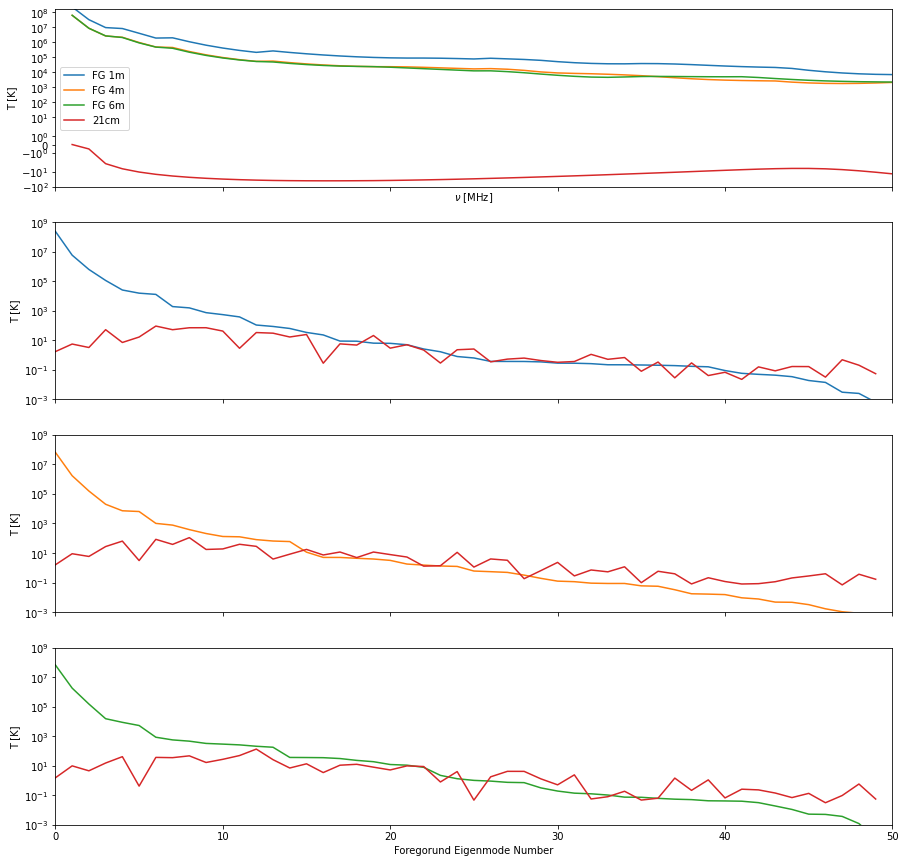

In [212]:
fig, axs = plt.subplots(figsize=(15,15), nrows=4, sharey=False, sharex=True)

# freq basis
axs[0].set_yscale("symlog")
axs[0].set_ylim(-1e2, 16e7)
axs[0].plot(freq/1e6, fg_freq_1m, label="FG 1m")
axs[0].plot(freq/1e6, fg_freq_4m, label="FG 4m")
axs[0].plot(freq/1e6, fg_freq_6m, label="FG 6m")
axs[0].plot(freq/1e6, interp_21cm, label="21cm")
axs[0].legend()
axs[0].set_xlabel("$\\nu$ [MHz]")

# 1m
sort_idx = np.argsort(fg_eig_1m.copy())[::-1]
fg = fg_eig_1m[sort_idx]
model = np.abs(V_1m @ interp_21cm.T)[sort_idx]
axs[1].set_yscale("log")
axs[1].plot(fg, color="C0")
axs[1].plot(model, color="C3")

# 4m
sort_idx = np.argsort(fg_eig_4m.copy())[::-1]
fg = fg_eig_4m[sort_idx]
model = np.abs(V_4m @ interp_21cm.T)[sort_idx]
axs[2].set_yscale("log")
axs[2].plot(fg, color="C1")
axs[2].plot(model, color="C3")

# 6m
sort_idx = np.argsort(fg_eig_6m.copy())[::-1]
fg = fg_eig_6m[sort_idx]
model = np.abs(V_6m @ interp_21cm.T)[sort_idx]
axs[3].set_yscale("log")
axs[3].plot(fg, color="C2")
axs[3].plot(model, color="C3")
axs[3].set_xlabel("Foregorund Eigenmode Number")

plt.setp(axs, xlim=(0, 50))
plt.setp(axs[1:], ylim=(1e-3, 1e9))
plt.setp(axs, ylabel="T [K]")
plt.show()

In [213]:
def eigen_result(V, fg):
    above = np.abs(V @ interp_21cm.T) - np.abs(fg)
    mask = np.where(above > 0, 1, 0)
    print(f"The 21-cm signal is brighter at {len(np.where(mask>0)[0])} eigenmodes.")
    print("In total, the 21-cm model is {:.2f} K brighter at those eigenmodes.".format(np.sum(above*mask)))
    print("Thus, when brighter, the 21-cm model is on average {:.2f} K brighter than the foregrounds.".format(
    np.sum(above*mask) / len(np.where(mask>0)[0])
    ))

In [214]:
print("1m antenna:\n***********")
eigen_result(V_1m, fg_eig_1m)
print("\n-------------------------\n")
print("4m antenna:\n***********")
eigen_result(V_4m, fg_eig_4m)
print("\n-------------------------\n")
print("6m antenna:\n***********")
eigen_result(V_6m, fg_eig_6m)

1m antenna:
***********
The 21-cm signal is brighter at 21 eigenmodes.
In total, the 21-cm model is 21.70 K brighter at those eigenmodes.
Thus, when brighter, the 21-cm model is on average 1.03 K brighter than the foregrounds.

-------------------------

4m antenna:
***********
The 21-cm signal is brighter at 33 eigenmodes.
In total, the 21-cm model is 55.92 K brighter at those eigenmodes.
Thus, when brighter, the 21-cm model is on average 1.69 K brighter than the foregrounds.

-------------------------

6m antenna:
***********
The 21-cm signal is brighter at 23 eigenmodes.
In total, the 21-cm model is 19.21 K brighter at those eigenmodes.
Thus, when brighter, the 21-cm model is on average 0.84 K brighter than the foregrounds.


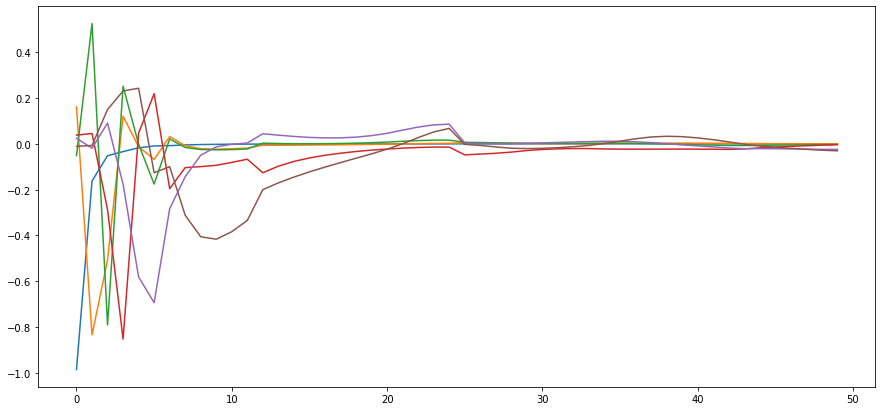

In [215]:
modes = eigenmodes(V_1m, 6)
plt.figure(figsize=(15,7))
for i in range(modes.shape[-1]):
    plt.plot(modes[:, i])
plt.show()

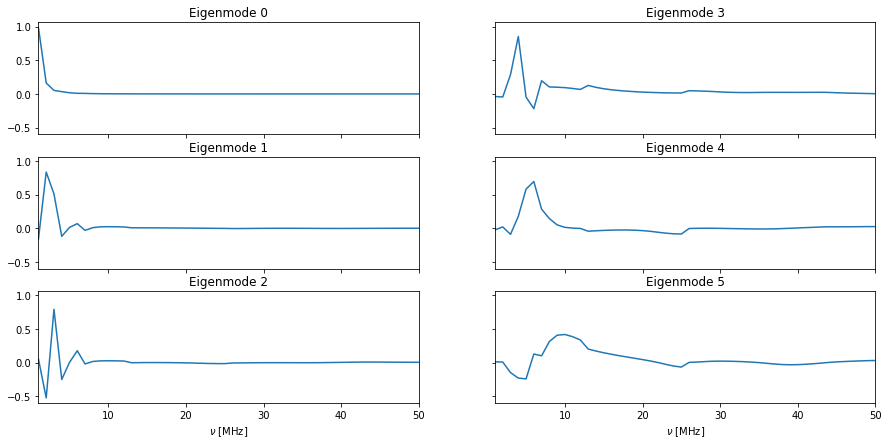

In [216]:
modes = eigenmodes(V_1m, 6)
fig, axs = plt.subplots(figsize=(15,7), nrows=3, ncols=2, sharex=True, sharey=True)
for row in range(3):
    for col in range(2):
        i = 3*col + row
        axs[row, col].plot(freq/1e6, -1*modes[:, i])
        axs[row, col].set_title(f"Eigenmode {i}")
        if row == 2:
            axs[row, col].set_xlabel("$\\nu$ [MHz]")
plt.setp(axs, xlim=(1, 50))
plt.show()

In [217]:
print(fg_eig_1m[sort_idx][:1].sum() / fg_eig_1m[sort_idx].sum() * 100)
print(fg_eig_1m[sort_idx][:6].sum() / fg_eig_1m[sort_idx].sum() * 100)

97.27970519500023
99.99132184136819
